In [20]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, precision_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [21]:
#Checking wich GPU is beeing used

!nvidia-smi

Wed Dec 15 14:30:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   28C    P2    63W / 250W |   7823MiB / 11019MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 30%   

In [22]:
#Load data
data_speaker_dir = 'dialogue/Dataset/VoiceDetection/mfcc/speakers.npy'
labels_dir = 'dialogue/Dataset/VoiceDetection/mfcc/labels.npy'

data_speaker = np.load(data_speaker_dir, allow_pickle = True)
labels = np.load(labels_dir, allow_pickle = True)

print(data_speaker.shape)
print(labels)

(36064, 40, 16)
[ True  True  True ... False False False]


In [23]:
test_labels = pd.read_csv("dialogue/Dataset/VoiceDetection/boolean_labels.csv")
test_labels.drop(test_labels.columns[[0]], axis=1, inplace=True)
test_labels = test_labels['isSpeaking'].to_numpy()
test_dir = 'dialogue/Dataset/VoiceDetection/mfcc/test.npy'
test_data_speaker = np.load(test_dir, allow_pickle = True)
print(test_data_speaker.shape)

(2300, 40, 16)


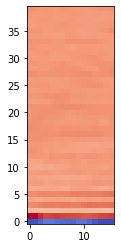

In [24]:
from matplotlib import cm
fig, ax = plt.subplots()
mfcc_data = data_speaker[-1]
cox = ax.imshow(mfcc_data, interpolation = 'nearest', cmap = cm.coolwarm, origin = 'lower')
plt.show()

In [25]:
#df_data.drop(['isSpeaking'],axis = 1)
X_train, X_val, y_train, y_val = train_test_split(data_speaker, labels, test_size = 0.2, random_state = 23)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)
X_test = test_data_speaker
y_test = test_labels
print(type(X_train))
#print(X_train)

<class 'numpy.ndarray'>


In [26]:
#print(pd.DataFrame(X_train))
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


print(X_train.shape, y_train.shape)
#print(test_X.shape)
#print(X_train)


torch.Size([28851, 40, 16]) torch.Size([28851])


In [27]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 40, kernel_size=3, stride = 1) #1 input channels, 100 output channels
        self.conv2 = nn.Conv1d(40, 80, kernel_size=3, stride = 1) #100 input channels from previous Conv. layer, 75 out
        
        self.fc1 = nn.Linear(160, 100) #Fully-connected classifier layer
        self.fc2 = nn.Linear(100,1) #Fully-connected classifier layer
    
    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        x = x.reshape(len(x), -1)
        #point A
        #x = x.transpose(1, 2)
        
        #point B
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X_train.shape[1],kernel_size = 3)

In [28]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.00003)

In [29]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

In [30]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers = 4, pin_memory = True)
#val_dl = DataLoader(val_ds, batch_size= 32)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#X_train = X_train.to(device)
#y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
CNN = CNN.to(device)
criterion = criterion.to(device)

In [32]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [33]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results_acc = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_val'])
Results_loss = pd.DataFrame(columns = ['Epoch', 'Loss_train', 'Loss_val'])
Results_recall = pd.DataFrame(columns = ['Epoch', 'Recall_val'])
Results_prec = pd.DataFrame(columns = ['Epoch', 'Prec_val'])

for epoch in range(20):
    
    y_acc = torch.empty((batch_size),dtype= torch.int32, device = 'cuda')
    y_pred_acc = torch.empty((batch_size), device = 'cuda')
    
    for x, y in train_dl:

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = CNN(x)
        y_pred = y_pred.squeeze()
        train_loss = criterion(y_pred, y)
        train_loss.backward()
        optimizer.step()
        
        y_acc = torch.concat([y, y_acc], axis = 0)
        y_pred_acc = torch.concat([y_pred, y_pred_acc], axis = 0)
        
    if epoch % 1 == 0:

        train_acc = calculate_accuracy(y_acc, CNN.post_forward(y_pred_acc))
        train_loss = criterion(y_pred,y)
    
        y_val_pred = CNN(X_val)
        y_val_pred = torch.squeeze(y_val_pred)
        val_loss = criterion(y_val_pred, y_val)
        val_acc = calculate_accuracy(y_val, CNN.post_forward(y_val_pred))
        
        Confusion = confusion_matrix(y_val.cpu(),y_val_pred.ge(.5).view(-1).cpu())
    
        val_recall_voice = Confusion[1][1]/(Confusion[1][1] + Confusion[1][0])
        val_prec_voice = Confusion[1][1]/(Confusion[0][1] + Confusion[1][1])

        val_recall_Novoice = Confusion[0][0]/(Confusion[0][0] + Confusion[0][1])
        val_prec_Novoice = Confusion[0][0]/(Confusion[1][0] + Confusion[0][0])

        Acc = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_val': round_tensor(val_acc)}
        Loss = {'Epoch': epoch, 'Loss_train': round_tensor(train_loss), 'Loss_val': round_tensor(val_loss)}
        Recall = {'Epoch': epoch, 'Recall_val_voice': round_tensor(val_recall_voice), "Recall_val_Novoice": round_tensor(val_recall_Novoice)}
        Prec = {'Epoch': epoch,'Prec_val_voice': round_tensor(val_prec_voice), 'Prec_val_Novoice': round_tensor(val_prec_Novoice)}

        print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
val  set - loss: {round_tensor(val_loss)}, accuracy: {round_tensor(val_acc)}
''')
        
        Results_acc = Results_acc.append(Acc, ignore_index=True)
        Results_loss = Results_loss.append(Loss, ignore_index=True)
        Results_recall = Results_recall.append(Recall, ignore_index=True)
        Results_prec = Results_prec.append(Prec, ignore_index=True)

epoch 0
Train set - loss: 0.02, accuracy: 0.942
val  set - loss: 0.035, accuracy: 0.991

epoch 1
Train set - loss: 0.006, accuracy: 0.993
val  set - loss: 0.015, accuracy: 0.997

epoch 2
Train set - loss: 0.005, accuracy: 0.995
val  set - loss: 0.01, accuracy: 0.997

epoch 3
Train set - loss: 0.007, accuracy: 0.995
val  set - loss: 0.008, accuracy: 0.998

epoch 4
Train set - loss: 0.008, accuracy: 0.996
val  set - loss: 0.007, accuracy: 0.998

epoch 5
Train set - loss: 0.01, accuracy: 0.996
val  set - loss: 0.007, accuracy: 0.998

epoch 6
Train set - loss: 0.01, accuracy: 0.997
val  set - loss: 0.006, accuracy: 0.998

epoch 7
Train set - loss: 0.011, accuracy: 0.997
val  set - loss: 0.006, accuracy: 0.998

epoch 8
Train set - loss: 0.01, accuracy: 0.997
val  set - loss: 0.006, accuracy: 0.999

epoch 9
Train set - loss: 0.011, accuracy: 0.997
val  set - loss: 0.006, accuracy: 0.999

epoch 10
Train set - loss: 0.011, accuracy: 0.997
val  set - loss: 0.006, accuracy: 0.999

epoch 11
Train

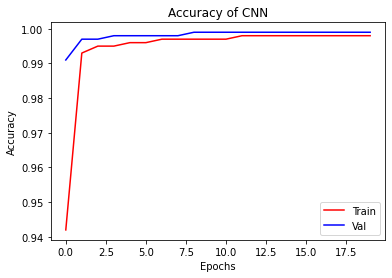

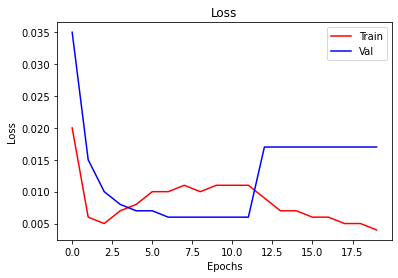

In [34]:
plt.plot(Results_acc.Epoch,Results_acc.Acc_train,'r',Results_acc.Epoch,Results_acc.Acc_val,'b')
plt.legend(['Train','Val'])
plt.title('Accuracy of CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

plt.plot(Results_loss.Epoch,Results_loss.Loss_train,'r',Results_loss.Epoch,Results_loss.Loss_val,'b')
plt.legend(['Train','Val'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

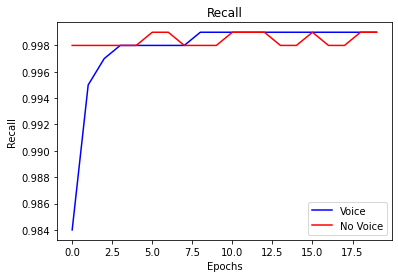

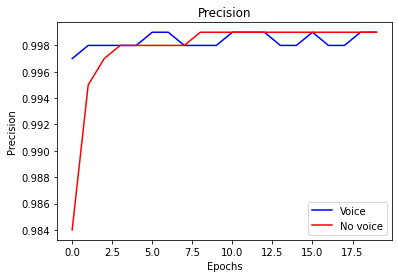

In [35]:
plt.plot(Results_recall.Epoch , Results_recall.Recall_val_voice,'b', Results_recall.Recall_val_Novoice,'r')
plt.legend(['Voice', 'No Voice'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.show()

plt.plot(Results_prec.Epoch,Results_prec.Prec_val_voice,'b', Results_prec.Prec_val_Novoice,'r')
plt.legend(['Voice', 'No voice'])
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.show()

In [36]:
classes = ['No Voice', 'Voice']
y_pred = CNN(X_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       1.00      1.00      1.00      3600
       Voice       1.00      1.00      1.00      3613

    accuracy                           1.00      7213
   macro avg       1.00      1.00      1.00      7213
weighted avg       1.00      1.00      1.00      7213



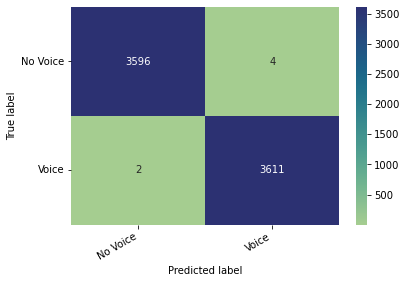

In [37]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
#hmap.color_palette("viridis", as_cmap=True)
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [38]:
y_pred = CNN(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.54      0.43      0.48      1256
       Voice       0.45      0.55      0.49      1044

    accuracy                           0.49      2300
   macro avg       0.49      0.49      0.49      2300
weighted avg       0.50      0.49      0.49      2300



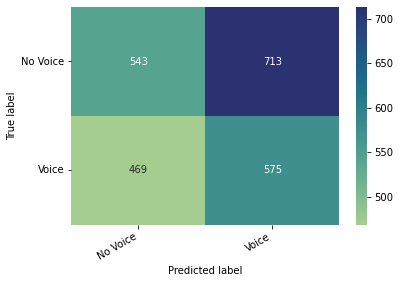

In [39]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [40]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
